In [1]:
import os
import tempfile
import zipfile

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Dataset

In [2]:
eiffel_tower = np.load("eiffel_tower.npy")
mona_lisa = np.load("mona_lisa.npy")

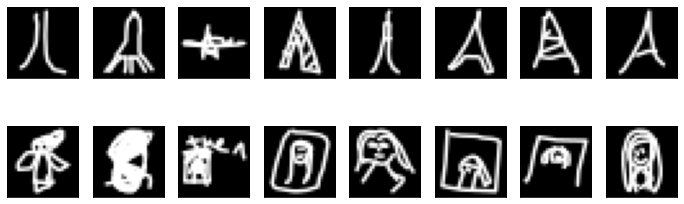

In [3]:
plt.figure(figsize=(12, 4))
for ind, i in enumerate(np.random.randint(0, eiffel_tower.shape[-1], 8)):
    plt.subplot(2, 8, ind + 1)
    plt.imshow(eiffel_tower[i, :].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.tick_params(bottom=False, left=False)
for ind, i in enumerate(np.random.randint(0, mona_lisa.shape[-1], 8)):
    plt.subplot(2, 8, ind + 1 + 8)
    plt.imshow(mona_lisa[i, :].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.tick_params(bottom=False, left=False)
plt.show()

In [4]:
x_all = np.vstack([eiffel_tower, mona_lisa]).reshape(-1, 28, 28)
y_all = np.array([1] * eiffel_tower.shape[0] + [0] * mona_lisa.shape[0])

perm = np.random.permutation(len(y_all))
x_all_shuffled = x_all[perm]
y_all_shuffled = y_all[perm]

x_train = x_all_shuffled[:200_000, :, :] / 255.
x_test = x_all_shuffled[200_000:, :, :] / 255.
y_train = y_all_shuffled[:200_000]
y_test = y_all_shuffled[200_000:]

# Baseline model

In [5]:
def get_model():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28)),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

def evaluate_tflite_model(filename, x_test, y_test):
    interpreter = tf.lite.Interpreter(model_path=filename)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    y_pred = []
    for test_image in x_test:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        y_pred.append(output()[0][0] >= 0.5)
    return (y_pred == np.array(y_test)).mean()

def get_gzipped_model_size(file):
    _, zipped_file = tempfile.mkstemp(".zip")
    with zipfile.ZipFile(zipped_file, "w", compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)

In [6]:
model_baseline = get_model()
model_baseline.save_weights("weights_baseline.h5")

2023-04-16 19:17:16.067374: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model_baseline.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_baseline.fit(
    x_train, 
    y_train, 
    epochs=1,
)

model_baseline_acc = model_baseline.evaluate(x_test, y_test)[-1]
print(f"Baseline accuracy: {model_baseline_acc}")

model_baseline.save("model_baseline.h5", include_optimizer=False)
model_baseline_size = os.path.getsize("model_baseline.h5")
model_baseline_size_gzipped = get_gzipped_model_size("model_baseline.h5")
print(f"Baseline size: {model_baseline_size}")
print(f"Baseline size (gzipped): {model_baseline_size_gzipped}")

1756/1756 [==============================] - 2s 1ms/step - loss: 0.0411 - accuracy: 0.9852
Baseline accuracy: 0.9852449297904968
Baseline size: 34352
Baseline size (gzipped): 14793


In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_baseline)
model_baseline_tflite = converter.convert()

with open("model_baseline.tflite", "wb") as f:
    f.write(model_baseline_tflite)
    
model_baseline_tflite_acc = evaluate_tflite_model("model_baseline.tflite", x_test, y_test)
print(f"Baseline accuracy: {model_baseline_tflite_acc}")

model_baseline_tflite_size = os.path.getsize("model_baseline.tflite")
model_baseline_tflite_size_gzipped = get_gzipped_model_size("model_baseline.tflite")
print(f"Baseline tflite size: {model_baseline_tflite_size}")
print(f"Baseline tflite size (gzipped): {model_baseline_tflite_size_gzipped}")

2023-04-16 19:17:45.569210: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpyq8zj1pp/assets


2023-04-16 19:17:47.605797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-04-16 19:17:47.605809: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-04-16 19:17:47.606310: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpyq8zj1pp
2023-04-16 19:17:47.607676: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-04-16 19:17:47.607687: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpyq8zj1pp
2023-04-16 19:17:47.613060: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-16 19:17:47.644176: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpyq8zj1pp
2023-04-

Baseline accuracy: 0.9852449095827994
Baseline tflite size: 17016
Baseline tflite size (gzipped): 14303


# Post-training quantization

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_baseline)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
model_quantized_tflite = converter.convert()

with open("model_quantized.tflite", "wb") as f:
    f.write(model_quantized_tflite)
    
model_quantized_tflite_acc = evaluate_tflite_model("model_quantized.tflite", x_test, y_test)
print(f"Quantized accuracy: {model_quantized_tflite_acc}")

model_quantized_tflite_size = os.path.getsize("model_quantized.tflite")
model_quantized_tflite_size_gzipped = get_gzipped_model_size("model_quantized.tflite")
print(f"Quantized size: {model_quantized_tflite_size}")
print(f"Quantized size (gzipped): {model_quantized_tflite_size_gzipped}")

INFO:tensorflow:Assets written to: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpqf2rux9a/assets


INFO:tensorflow:Assets written to: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpqf2rux9a/assets
2023-04-16 19:17:58.154653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-04-16 19:17:58.154666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-04-16 19:17:58.154777: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpqf2rux9a
2023-04-16 19:17:58.156312: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-04-16 19:17:58.156323: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpqf2rux9a
2023-04-16 19:17:58.160807: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-16 19:17:58.191651: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

Quantized accuracy: 0.98526270824434
Quantized size: 9968
Quantized size (gzipped): 7483


# Weights pruning

In [2]:
def monotonically_increasing_decay(x):
    return -50 * np.exp(-0.05 * x) + 80

# Generate x-values
x = np.linspace(0, 100, 100)

# Generate y-values using the monotonically increasing decay function
y = monotonically_increasing_decay(x)

# Rescale y-values to start at 50 and end at 80
y_range = y.max() - y.min()
y = (y - y.min()) * (30 / y_range) + 50

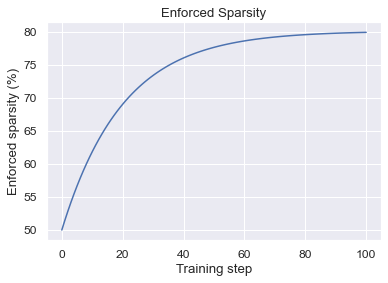

In [21]:
# Create a line plot using seaborn
sns.lineplot(x=x, y=y, palette=sns.color_palette("Set2"))

# Set plot title and axis labels
plt.title("Enforced Sparsity")
plt.xlabel("Training step")
plt.ylabel("Enforced sparsity (%)")

sns.set_style("whitegrid")
sns.set(font_scale=1.1)
plt.show()

In [10]:
batch_size = 128
epochs = 2
validation_split = 0.1

x_train_size = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(x_train_size / batch_size).astype(np.int32) * epochs

pruning_params = {
    "pruning_schedule": tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.50,
        final_sparsity=0.80,
        begin_step=0,
        end_step=end_step,
    )
}

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(model_baseline, **pruning_params)


model_pruned.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_pruned.fit(
    x_train, 
    y_train, 
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()],
)

model_pruned_acc = model_pruned.evaluate(x_test, y_test)[-1]
print(f"Pruned aware accuracy: {model_pruned_acc}")

Epoch 1/2
5625/5625 [==============================] - 30s 5ms/step - loss: 0.0449 - accuracy: 0.9840 - val_loss: 0.0440 - val_accuracy: 0.9833
Epoch 2/2
1756/1756 [==============================] - 3s 2ms/step - loss: 0.0442 - accuracy: 0.9840
Pruned aware accuracy: 0.9840167760848999


In [11]:
model_pruned = tfmot.sparsity.keras.strip_pruning(model_pruned)

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_pruned)
model_pruned_tflite = converter.convert()

with open("model_pruned.tflite", "wb") as f:
    f.write(model_pruned_tflite)
    
model_pruned_tflite_acc = evaluate_tflite_model("model_pruned.tflite", x_test, y_test)
print(f"Pruned accuracy: {model_pruned_tflite_acc}")

model_pruned_tflite_size = os.path.getsize("model_pruned.tflite")
model_pruned_tflite_size_gzipped = get_gzipped_model_size("model_pruned.tflite")
print(f"Pruned size: {model_pruned_tflite_size}")
print(f"Pruned size (gzipped): {model_pruned_tflite_size_gzipped}")

INFO:tensorflow:Assets written to: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpvx98i331/assets


INFO:tensorflow:Assets written to: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpvx98i331/assets
2023-04-16 19:19:47.943828: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-04-16 19:19:47.943842: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-04-16 19:19:47.943944: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpvx98i331
2023-04-16 19:19:47.945110: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-04-16 19:19:47.945122: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpvx98i331
2023-04-16 19:19:47.948719: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-16 19:19:47.962732: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

Pruned accuracy: 0.9840168019364943
Pruned size: 17016
Pruned size (gzipped): 5862


# Weights pruning + quantization

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_pruned)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
model_pruned_quantized_tflite = converter.convert()

with open("model_pruned_quantized.tflite", "wb") as f:
    f.write(model_pruned_quantized_tflite)
    
model_pruned_quantized_tflite_acc = evaluate_tflite_model("model_pruned_quantized.tflite", x_test, y_test)
print(f"Pruned+Quantized accuracy: {model_pruned_quantized_tflite_acc}")

model_pruned_quantized_tflite_size = os.path.getsize("model_pruned_quantized.tflite")
model_pruned_quantized_tflite_size_gzipped = get_gzipped_model_size("model_pruned_quantized.tflite")
print(f"Pruned+Quantized size: {model_pruned_quantized_tflite_size}")
print(f"Pruned+Quantized size (gzipped): {model_pruned_quantized_tflite_size_gzipped}")

INFO:tensorflow:Assets written to: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpnz1ouw_3/assets


INFO:tensorflow:Assets written to: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpnz1ouw_3/assets
2023-04-16 19:19:58.194961: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-04-16 19:19:58.194973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-04-16 19:19:58.195069: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpnz1ouw_3
2023-04-16 19:19:58.196111: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-04-16 19:19:58.196121: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/jf/dnk7cw8j745714wzs224mcj80000gn/T/tmpnz1ouw_3
2023-04-16 19:19:58.199452: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-16 19:19:58.214152: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

Pruned+Quantized accuracy: 0.9840168019364943
Pruned+Quantized size: 9968
Pruned+Quantized size (gzipped): 3996


# Viz

In [17]:
df = pd.DataFrame({
    "model": ["baseline", "quantized", "pruned", "pruned + quantized"],
    "size": [
        model_baseline_tflite_size_gzipped,
        model_quantized_tflite_size_gzipped,
        model_pruned_tflite_size_gzipped, 
        model_pruned_quantized_tflite_size_gzipped,
    ],
    "accuracy": [
        model_baseline_tflite_acc,
        model_quantized_tflite_acc,
        model_pruned_tflite_acc, 
        model_pruned_quantized_tflite_acc,
    ],
})
df

,model,size,accuracy
0,baseline,14303,0.985245
1,quantized,7483,0.985263
2,pruned,5862,0.984017
3,pruned + quantized,3996,0.984017


In [25]:
sns.set_style("whitegrid")
sns.set(font_scale=1.1)

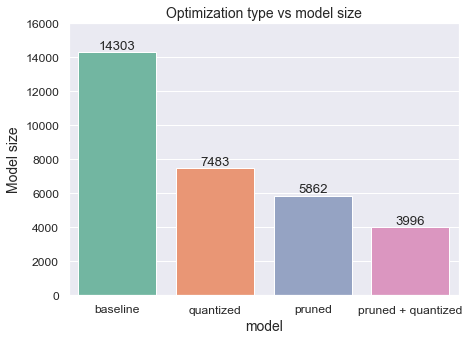

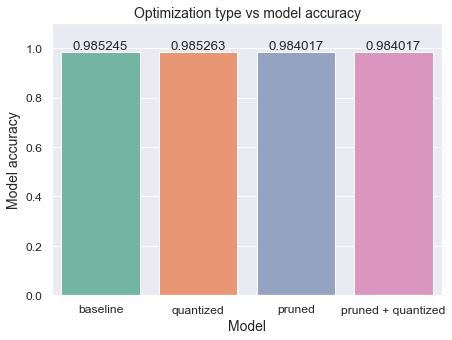

In [28]:
plt.figure(figsize=(7,5))
ax = sns.barplot(data=df, x="model", y="size", palette=sns.color_palette("Set2"))
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Optimization type vs model size", fontsize=14)
plt.xlabel("model", fontsize=14)
plt.ylabel("Model size", fontsize=14)
plt.ylim(0, 16_000)
plt.show()

plt.figure(figsize=(7,5))
ax = sns.barplot(data=df, x="model", y="accuracy", palette=sns.color_palette("Set2"))
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Optimization type vs model accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Model accuracy", fontsize=14)
plt.ylim(0, 1.1)
plt.show()